In [1]:
import numpy as np
from scipy.linalg import eigh
import urllib.request
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from tqdm import tqdm 

In [5]:
def load_uci_digits():
    # 数据集URL地址（官网数据）
    base_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mfeat/"
    files = ["mfeat-fou", "mfeat-fou", "mfeat-kar", "mfeat-pix", "mfeat-zer", "mfeat-mor"]

    views = []
    for file in ["mfeat-fac", "mfeat-fou", "mfeat-kar", "mfeat-pix", "mfeat-zer", "mfeat-mor"]:
        url = base_url + file
        response = urllib.request.urlopen(url)
        data = response.read().decode('utf-8').strip().split('\n')
        view = np.array([list(map(float, line.strip().split())) for line in data])
        view = view[:2000, :]  # 只取前2000个样本（每个类别200个，共10个类别）
        views.append(view)

    return views

# 加载数据
views = list(load_uci_digits())
for idx, view in enumerate(views):
    print(f"View {idx+1} shape:", view.shape)

View 1 shape: (2000, 216)
View 2 shape: (2000, 76)
View 3 shape: (2000, 64)
View 4 shape: (2000, 240)
View 5 shape: (2000, 47)
View 6 shape: (2000, 6)


In [19]:
views = load_uci_digits()
X1, X2, X3, X4, X5, X6 = views

In [18]:
import numpy as np
from scipy.linalg import eigh

In [31]:
def project_simplex(v):
    """
    将向量 v 投影到概率单纯形上，即：
       w = argmin_{w} ||w - v||^2,  s.t. sum(w)=1,  w >= 0.
    参考论文: Wang & Carreira-Perpinan (2013) "Projection onto the probability simplex".
    """
    n = len(v)
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u + (1 - cssv) / (np.arange(n) + 1) > 0)[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1)
    w = np.maximum(v - theta, 0)
    return w

def compute_laplacian(S):

    D = np.diag(S.sum(axis=1))
    L = D - S
    return L

def update_S(Q, beta):
    """
    对于给定的嵌入矩阵 Q（大小 n x c），按照公式 (9)
    对 S 的每一列进行更新：
       对 j = 0,..., n-1, 计算 g_ij = ||q_i - q_j||^2 for i=0,..., n-1,
       然后 s_j = projection_simplex( -g_j/(2*beta) ).
    返回更新后的 S（大小 n x n）。
    """
    n, c = Q.shape
    S = np.zeros((n, n))
    # 预先计算所有点之间的欧氏距离的平方（针对嵌入 Q）
    # Q_norms 是长度为 n 的向量， q_i^2
    Q_norms = np.sum(Q**2, axis=1, keepdims=True)
    # dist_sq[i,j] = ||q_i - q_j||^2 = ||q_i||^2 + ||q_j||^2 - 2 q_i^T q_j.
    dist_sq = Q_norms + Q_norms.T - 2 * np.dot(Q, Q.T)
    # 保证非负数
    dist_sq = np.maximum(dist_sq, 0)
    
    for j in range(n):
        # 对于第 j 列（对应数据点 j）
        g_j = dist_sq[:, j]
        # 计算辅助向量 v = - g_j/(2*beta)
        v = -g_j / (2 * beta)
        # 投影到概率单纯形
        s_j = project_simplex(v)
        S[:, j] = s_j
        
    return S

def update_Q(L, c):
    """
    对于对称拉普拉斯矩阵 L（大小 n x n），获取最小 c 个特征值对应的特征向量，
    构成嵌入矩阵 Q（大小 n x c）。
    使用 scipy.linalg.eigh 默认返回的特征值按升序排序。
    """
    # eigh保证L为对称矩阵
    eigvals, eigvecs = eigh(L)
    Q = eigvecs[:, :c]
    return Q, eigvals

def single_view_graph_learning(X, c, beta=1.0, max_iter=100, tol_eig=1e-5, verbose=True):
    """
    单视图图学习算法
    输入:
        X       : 数据矩阵 (n x d), 每一行为一个数据点的特征
        c       : 聚类数目，即期望图的连通分支个数
        beta    : 正则化因子
        max_iter: 最大迭代次数
        tol_eig : 判断零特征值（图连通）的阈值
    输出:
        S       : 学习得到的相似性矩阵 (n x n)
        Q       : 嵌入矩阵 (n x c)
    """
    n, d = X.shape

    # --- 初始化 ---
    # 这里为了简单，我们使用均匀初始化，每个列向量均为 [1/n, 1/n, ..., 1/n]^T
    S = np.ones((n, n)) / n
    # 确保 S 对称
    S = (S + S.T) / 2
    L = compute_laplacian(S)
    Q, eigvals = update_Q(L, c)
    
    for it in range(max_iter):
        # --- 更新 S ---
        S = update_S(Q, beta)
        # 为了保证拉普拉斯矩阵为对称矩阵，这里对 S 做对称化处理
        S = (S + S.T) / 2
        
        # --- 更新 Q ---
        L = compute_laplacian(S)
        Q_new, eigvals = update_Q(L, c)
        
        # 打印当前最小 c 个特征值，可以用来观察是否达到理想连通性（即零特征值个数为 c）
        if verbose:
            print(f"Iter {it+1}, smallest eigenvalues: {eigvals[:c]}")
        
        # 检查是否收敛：这里简单使用 Q 的收敛检测（也可根据特征值进行判断）
        if np.linalg.norm(Q - Q_new, 'fro') / np.linalg.norm(Q, 'fro') < 1e-4:
            Q = Q_new
            break
        Q = Q_new
        
        # 或者检查拉普拉斯矩阵是否达到 c 个接近于 0 的特征值（说明图有 c 个连通分量）
        num_zero_eig = np.sum(eigvals < tol_eig)
        if num_zero_eig >= c:
            if verbose:
                print(f"Converged: the Laplacian has {num_zero_eig} (>= {c}) zero eigenvalues.")
            break
        
    return S, Q


In [51]:
def project_simplex(v):
    """
    将向量 v 投影到概率单纯形上，即：
       w = argmin_{w} ||w - v||^2,  s.t. sum(w)=1,  w >= 0.
    参考论文: Wang & Carreira-Perpinan (2013) "Projection onto the probability simplex".
    """
    n = len(v)
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u + (1 - cssv) / (np.arange(n) + 1) > 0)[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1)
    w = np.maximum(v - theta, 0)
    return w

def compute_laplacian(S):
    D = np.diag(S.sum(axis=1))
    L = D - S
    return L

def update_S(Q, beta):
    n, c = Q.shape
    S = np.zeros((n, n))
    # 预先计算所有点之间的欧氏距离的平方（针对嵌入 Q）
    # Q_norms 是长度为 n 的向量， q_i^2
    Q_norms = np.sum(Q**2, axis=1, keepdims=True)
    # dist_sq[i,j] = ||q_i - q_j||^2 = ||q_i||^2 + ||q_j||^2 - 2 q_i^T q_j.
    dist_sq = Q_norms + Q_norms.T - 2 * np.dot(Q, Q.T)
    # 保证非负数
    dist_sq = np.maximum(dist_sq, 0)
    
    for j in range(n):
        # 对于第 j 列（对应数据点 j）
        g_j = dist_sq[:, j]
        # 计算辅助向量 v = - g_j/(2*beta)
        v = -g_j / (2 * beta)
        # 投影到概率单纯形
        s_j = project_simplex(v)
        S[:, j] = s_j
        
    return S

def update_Q(L, c):
    """
    对于对称拉普拉斯矩阵 L（大小 n x n），获取最小 c 个特征值对应的特征向量，
    构成嵌入矩阵 Q（大小 n x c）。
    使用 scipy.linalg.eigh 默认返回的特征值按升序排序。
    """
    # eigh保证L为对称矩阵
    eigvals, eigvecs = eigh(L)
    Q = eigvecs[:, :c]
    return Q, eigvals

In [52]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.decomposition import KernelPCA

In [59]:

def get_similarity_matrix(X):
    sigma = 1.0  # 控制衰减速度
    sim_matrix = rbf_kernel(X, gamma=1/(2*sigma**2))
def make_single_view_graph(single_view_graph_X, class_number, default_beta=1.0):
    
    single_view_graph = []
    
    for i in tqdm(range(len(single_view_graph_X))):
        
        # transformation
        kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
        X_kpca = kpca.fit_transform(single_view_graph_X[i])
        
        # init
        beta = default_beta
        similarity_matrix = get_similarity_matrix(X_kpca)
        S = update_S(X_kpca, beta)
        L = compute_laplacian(S)
        Q, eigs = update_Q(L, class_number)

        for j in range(100):
            S = update_S(Q, beta)
            S = (S + S.T) / 2
            L = compute_laplacian(S)
            Q_new, eigvals = update_Q(L, c)

        if np.linalg.norm(Q - Q_new, 'fro') / np.linalg.norm(Q, 'fro') < 1e-4:
            tqdm.write(f"{i}th graph end at {j}th iteration, smallest eigenvalues: {eigvals[:c]}")
            break
        Q = Q_new
        num_zero_eig = np.sum(eigvals < 1e-5)
        if num_zero_eig >= c:
            tqdm.write(f"Converged: the Laplacian has {num_zero_eig} (>= {c}) zero eigenvalues.")
            break
        single_view_graph.append(S)
        
    return single_view_graph

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate two-moon datasets
graph_number = 10
single_view_graph_X = []
for i in range(graph_number):
    X, y = make_moons(n_samples=100, noise=0.05, random_state=i+10)
    single_view_graph_X.append(X)

In [61]:
class_number = 2

single_view_graph = make_single_view_graph(single_view_graph_X, class_number)

100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


In [62]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from matplotlib.colors import ListedColormap


def plot_clusters_multi(X_list, S_list, n_nearest=5):
    # Ensure the input lists are of the same length
    assert len(X_list) == len(S_list), "X_list and S_list must have the same number of elements"
    
    n_datasets = len(X_list)
    rows = int(np.ceil(np.sqrt(n_datasets)))
    cols = int(np.ceil(n_datasets / rows))
    
    plt.figure(figsize=(6 * cols, 4 * rows))
    
    for idx in range(n_datasets):
        X = X_list[idx]
        S = S_list[idx]
        
        # Perform spectral clustering
        model = SpectralClustering(n_clusters=2, affinity='precomputed',
                                   assign_labels='discretize', random_state=42)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", 
                message="Array is not symmetric, and will be converted to symmetric*")
            warnings.filterwarnings("ignore",
                message="Graph is not fully connected, spectral embedding*")
            clusters = model.fit_predict(S)
        
        # Compute nearest neighbor connections
        n = X.shape[0]
        D = np.linalg.norm(X[:, np.newaxis, :] - X, axis=2)
        S_new = np.zeros((n, n), dtype=int)
        for i in range(n):
            nearest_neighbors = np.argsort(D[i])[1:n_nearest+1]
            S_new[i, nearest_neighbors] = 1
        
        # Create subplot
        plt.subplot(rows, cols, idx + 1)
        colors = ['blue', 'red']
        cmap = ListedColormap(colors)
        
        # Plot data points
        plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap=cmap,
                    edgecolor='k', s=50, zorder=2)
        
        # Plot intra-cluster connections
        for i in range(n):
            for j in range(i + 1, n):
                if (S_new[i, j] or S_new[j, i]) and clusters[i] == clusters[j]:
                    plt.plot([X[i, 0], X[j, 0]], [X[i, 1], X[j, 1]],
                             color=colors[clusters[i]], alpha=0.4, zorder=1)
        
        plt.title(f'Graph {idx} ({n_nearest} NN)')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
    
    plt.tight_layout()
    plt.show()

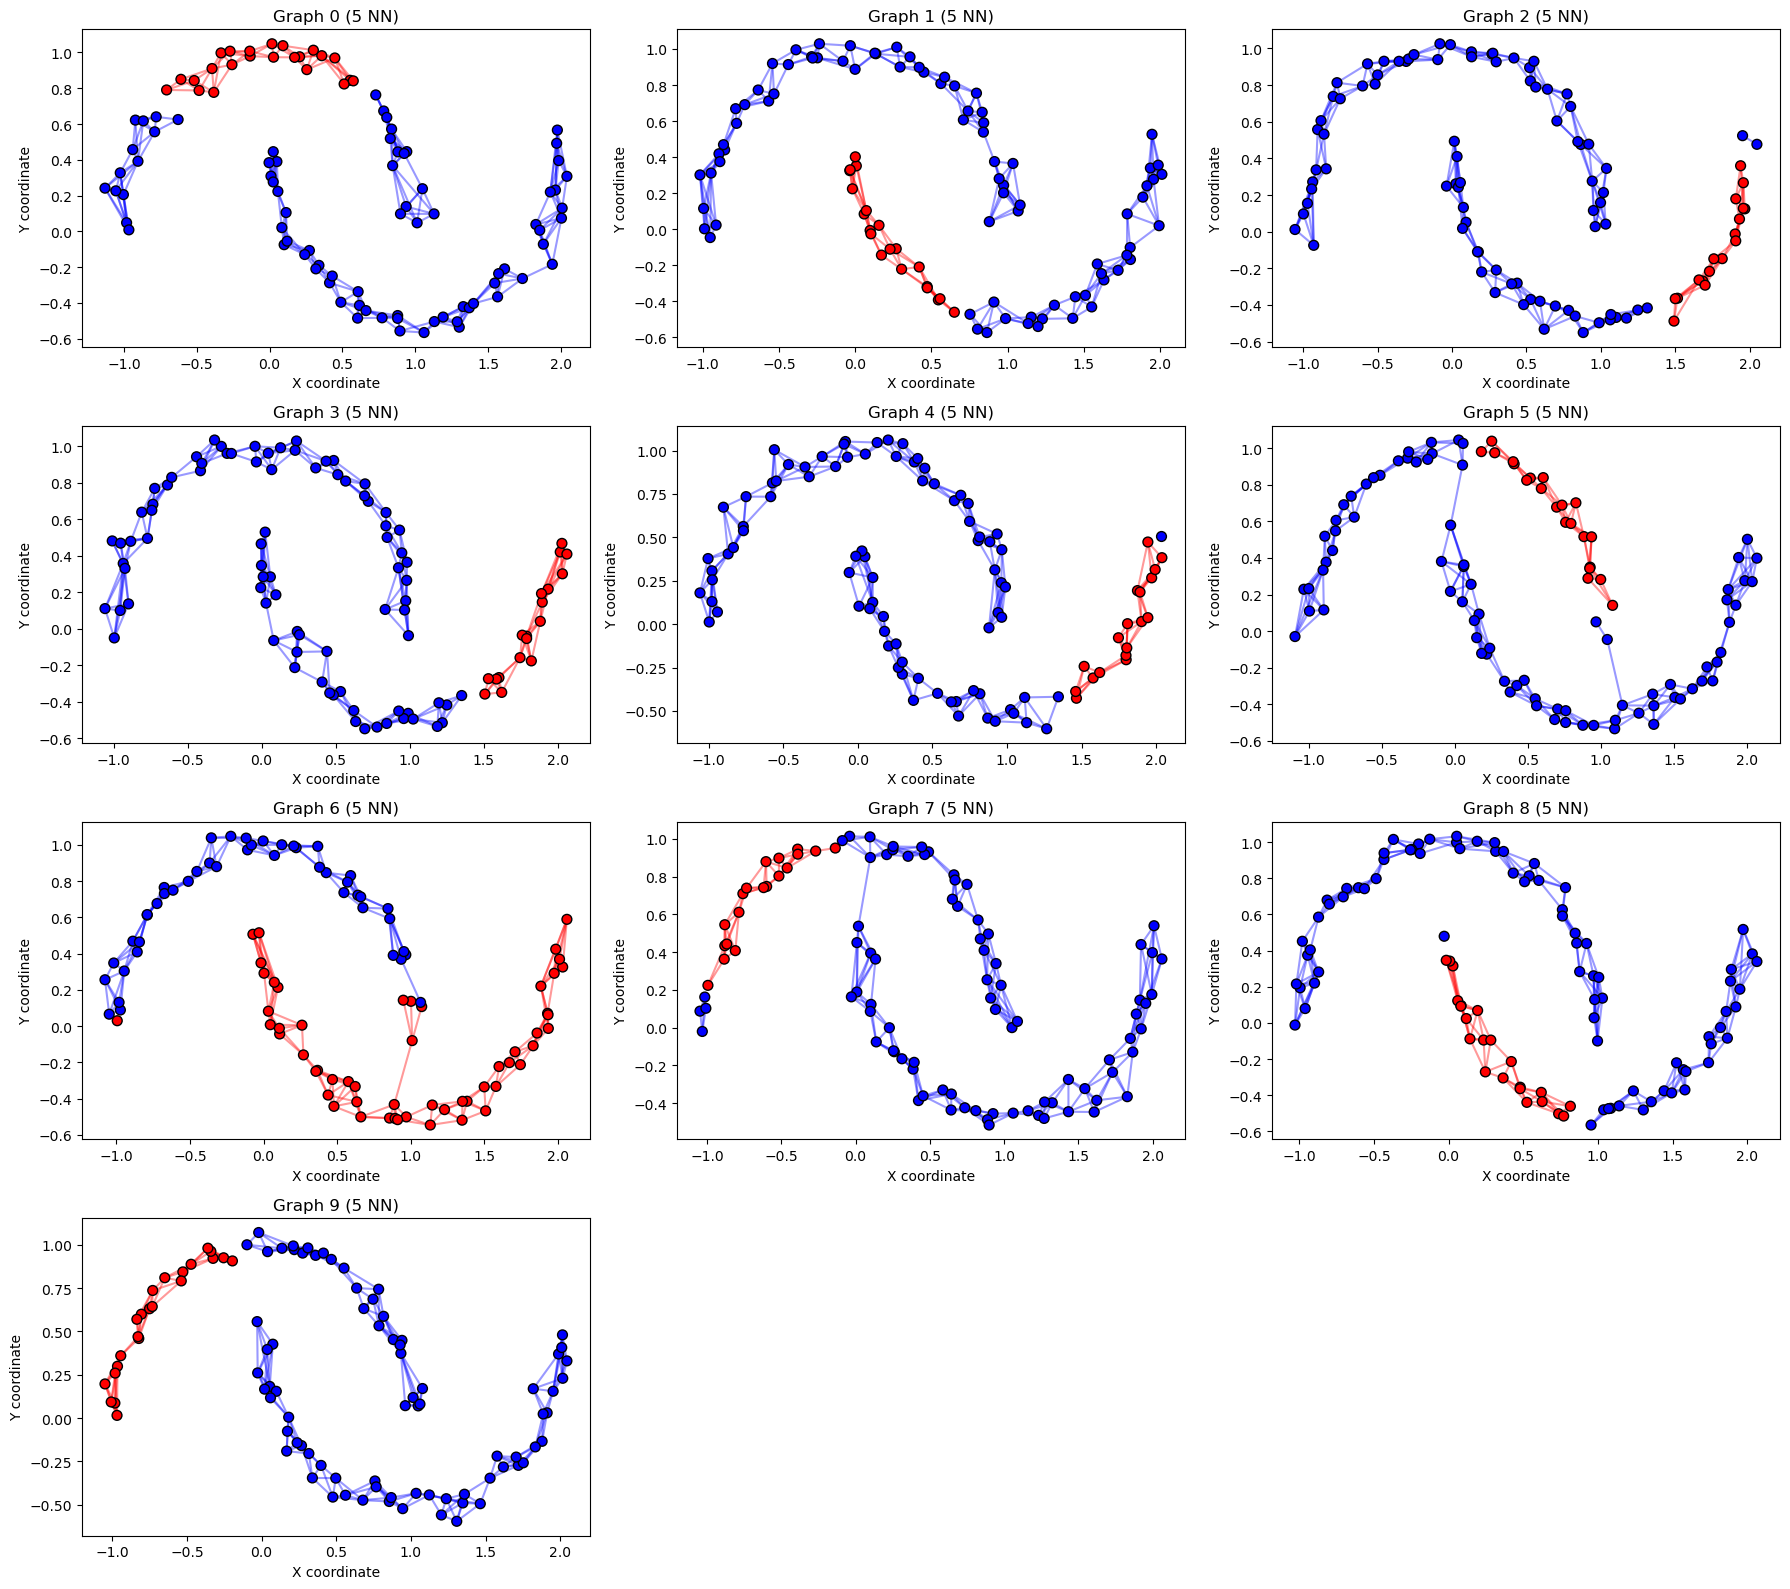

In [63]:
plot_clusters_multi(single_view_graph_X, single_view_graph)